Processing n=5 (1/1)

Relative estimation errors:
Shot Noise: 0.000076
Decoherence Noise: 0.003685
Compressed Sensing: 0.000527


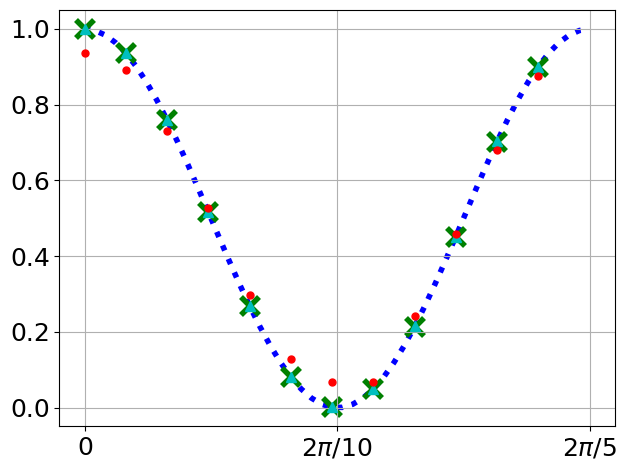

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
import cvxpy as cp
from scipy.optimize import curve_fit

def generate_noisy_data(amplitudes, frequencies, gamma):
    ideal = np.cos( amplitudes * frequencies )
    sigma_shot = (ideal**2)*(np.full(len(frequencies),1.0)-(ideal**2))/50 
    deco = np.cos( frequencies )**amplitudes
    sigma_deco = (deco**2)*(np.full(len(frequencies),1.0)-(deco**2))/50

    shot_gnal = np.random.normal(ideal,sigma_shot)
    deco_gnal = (1-gamma)*shot_gnal + gamma*np.random.normal(0,0.25, len(frequencies))#gamma*np.random.normal(deco,sigma_deco)
                 
    return ideal, shot_gnal, deco_gnal

def fit_alpha(G_vals, amplitudes, frequencies):
    def model(frequencies, nfit):
        return np.cos( nfit * frequencies )
    popt, pcov = curve_fit(model, frequencies, G_vals, p0=[0.8*amplitudes])
    qubit_est = popt[0]
    return qubit_est
    
def compressed_sensing(G_vals, ep):
    # Setup the optimization
    len_t = len(G_vals)
    g_var = cp.Variable(len_t)
    
    # Define symmetric Toeplitz matrix from cos_row
    T_entries = [[g_var[abs(i - j)] for j in range(len_t)] for i in range(len_t)]
    T_var = cp.bmat(T_entries)
    
    # Objective: minimize Trace norm to original T
    objective = cp.Minimize(cp.trace(T_var))
    # Constraints:
    constraints = [T_var>>0,cp.norm(g_var - G_vals, 1)<=ep]
    # Solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.CVXOPT)
    g_opt = g_var.value
    g_opt=g_opt/g_opt[0]
    if g_var.value is None:
        raise ValueError("Optimization failed. Try increasing `ep` or checking input.")
    return np.array(g_opt)

def compressed_sensing_extend(G_vals, ext_dim):
    # Setup the optimization
    len_t = len(G_vals)
    g_var = cp.Variable(ext_dim)
    
    # Define symmetric Toeplitz matrix from cos_row
    T_entries = [[g_var[abs(i - j)] for j in range(ext_dim)] for i in range(ext_dim)]
    T_var = cp.bmat(T_entries)
    
    # Objective: minimize Frobenius norm to original T
    objective = cp.Minimize(cp.norm(g_var[0:len_t] - G_vals, 2))
    # Constraints:
    constraints = [T_var>>0,cp.trace(T_var)==ext_dim]
    # Solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.CVXOPT)
    g_opt = g_var.value
    #g_opt=g_opt/g_opt[0]
    if g_var.value is None:
        raise ValueError("Optimization failed. Try increasing `ep` or checking input.")
    return np.array(g_opt)

####################
# MAIN ANALYSIS
####################

#Experimental parameters
n_values=[5] # Number of qubits
N = 12 # Number of measurement points (samples)
k=4 # Subsampling factor (every 4th point) of the freq grid
alpha_idx=50 # Total grid points
alpha_true_long=np.linspace(0,2*np.pi/n_values[0],alpha_idx,dtype=float) #Grid points
alpha_true=alpha_true_long[0:k*N:k] # Sampled points on the grid (12 in total)
R_trials = 25 # Number of Monte Carlo trials
duration=1
gammas=0.1 # Decoherence parameter
ep=0.25 # Base tolerance for compressed sensing


err_shot=np.zeros((len(n_values),R_trials), dtype=float)
err_deco=np.zeros((len(n_values),R_trials), dtype=float)
err_denoise=np.zeros((len(n_values),R_trials), dtype=float)
for n_idx, nqubit in enumerate(n_values):
    print(f"Processing n={nqubit} ({n_idx+1}/{len(n_values)})")
    for r in range(R_trials):
        clean_signal, shot_signal, deco_signal = generate_noisy_data(nqubit, alpha_true_long, gammas)
        try:
            denoise_signal =compressed_sensing(deco_signal[0:k*N:k], ep+(n_idx*0.01))
            err_denoise[n_idx,r]=fit_alpha(denoise_signal, nqubit, alpha_true)-nqubit#
        except ValueError:
            err_denoise[n_idx,r]=np.nan
        err_shot[n_idx,r]=fit_alpha( shot_signal[0:k*N:k], nqubit, alpha_true)-nqubit
        err_deco[n_idx,r]=fit_alpha( deco_signal[0:k*N:k], nqubit, alpha_true)-nqubit#
        
alpha_shot=np.mean(err_shot,axis=1)
alpha_deco=np.mean(err_deco,axis=1)
alpha_denoise=np.mean(err_denoise,axis=1)

# Print relative estimation errors
print(f"\nRelative estimation errors:")
print(f"Shot Noise: {abs(alpha_shot[0])/n_values[0]:6f}")
print(f"Decoherence Noise: {abs(alpha_deco[0])/n_values[0]:6f}")
print(f"Compressed Sensing: {abs(alpha_denoise[0])/n_values[0]:6f}")

fig, ax = plt.subplots()
ax.plot(alpha_true_long, 0.5*(1+clean_signal), 'b:',linewidth=4,zorder=0)
ax.plot(alpha_true_long[0:k*N:k], 0.5*(1+shot_signal[0:k*N:k]),'c^', markersize=7,zorder=2)
ax.plot(alpha_true_long[0:k*N:k], 0.5*(1+deco_signal[0:k*N:k]),'r.',markersize=10,zorder=2)
ax.plot(alpha_true_long[0:k*N:k], 0.5*(1+denoise_signal),'gx',markersize=13,zorder=1,markeredgewidth=4)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.set_xticks([0,2*np.pi/(2*n_values[0]),2*np.pi/n_values[0]])
ax.set_xticklabels(['$0$', f'$2\\pi/{2*n_values[0]}$', f'$2\\pi/{n_values[0]}$'])


plt.grid(True)
plt.tight_layout()
#plt.savefig("CompSensing.svg")
plt.show()